In [15]:
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [2]:
plt.rcParams["figure.figsize"] = (12,8)

# Example Nr. 3 - Predictive Maintenance

In this third example we're going to explore the predictive maintenance example that was presented in class.  

The focus is on learning how to perform a survival analysis in arc in order to obtain the same results shown to you during the lecture and for you to be able to perform your own survival analysis on your own datasets. 

Bear in mind that our issue in this example is to estimate the remaining lifetime of our PCs, so we can better organize our maintenance efforts.

In [3]:
df = pd.read_csv('../Datasets/DATA_4.03_MNT.csv')
df.head()

,lifetime,broken,pressureInd,moistureInd,temperatureInd,team,provider
0,56,0,92.178854,104.230204,96.517159,TeamA,Provider4
1,81,1,72.075938,103.065701,87.271062,TeamC,Provider4
2,60,0,96.272254,77.801376,112.196170,TeamA,Provider1
3,86,1,94.406461,108.493608,72.025374,TeamC,Provider2
4,34,0,97.752899,99.413492,103.756271,TeamB,Provider1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   lifetime        1000 non-null   int64  
 1   broken          1000 non-null   int64  
 2   pressureInd     1000 non-null   float64
 3   moistureInd     1000 non-null   float64
 4   temperatureInd  1000 non-null   float64
 5   team            1000 non-null   object 
 6   provider        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
lifetime,1000.0,55.195000,26.472737,1.000000,34.000000,60.000000,80.000000,93.000000
broken,1000.0,0.397000,0.489521,0.000000,0.000000,0.000000,1.000000,1.000000
pressureInd,1000.0,98.599338,19.964052,33.481917,85.558076,97.216997,112.253190,173.282541
moistureInd,1000.0,99.376723,9.988726,58.547301,92.771764,99.433959,106.120762,128.595038
temperatureInd,1000.0,100.628541,19.633060,42.279598,87.676913,100.592277,113.662885,172.544140


In [7]:
df.describe(include=['object'])

,team,provider
count,1000,1000
unique,3,4
top,TeamB,Provider2
freq,356,266


In [10]:
# Build a linear regression model
all_columns = "+".join(df.columns).replace('lifetime+', '')
my_formula = 'lifetime~' + all_columns + '-broken'
linregmodel = smf.ols(my_formula, data=df).fit()

In [14]:
linregmodel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               lifetime   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     4.346
Date:                Tue, 04 May 2021   Prob (F-statistic):           3.62e-05
Time:                        06:10:00   Log-Likelihood:                -4677.3
No. Observations:                1000   AIC:                             9373.
Df Residuals:                     991   BIC:                             9417.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                59.3732     10.341      5.741      0.000      39.080      79.666
team[T.TeamB]             1.5491      1.998      0.775      0.438      -2.372       5.471
team[T.TeamC]            -3.4280      2.067     -1.658      0.098      -7.484       0.628
provider[T.Provider2]     0.8836      2.294      0.385      0.700      -3.619       5.386
provider[T.Provider3]    -9.4858      2.349     -4.038      0.000     -14.096      -4.876
provider[T.Provider4]     1.8679      2.362      0.791      0.429      -2.766       6.502
pressureInd              -0.0031      0.042     -0.076      0.940      -0.085       0.079
moistureInd              -0.0173      0.083     -0.208      0.835      -0.180       0.146
temperatureInd           -0.0003      0.042     -0.007      0.995      -0.083       0.082
==============================================================================
Omnibus:                      247.903   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.393
Skew:                          -0.545   Prob(JB):                     2.35e-20
Kurtosis:                       2.009   Cond. No.                     2.17e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.17e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

What we see is that It looks like the fact that team C which was in charge of the maintenance of the piece is statistically significant, as well as the fact that the piece was provided by provider number three. And both of them seem to impact negatively on the lifetime if we look at the co efficient and its sign.

However, using the output of a linear regression in this case is inaccurate. We cannot rely on the output of the linear regression model for a very simple reason:60% of the observations are PC's that are still working. The lifetime represented by those is not the lifetime until the PC was broken, but rather, the lifetime until now. So the truth is, we don't really know what the final value of lifetime will be for PCs that are not broken yet. All we know is that they are still working until now.  

This is what we call a **right-censored problem**.

**Right censoring** occurs when a subject leaves the study before an event occurs, or the study ends before the event has occurred.
We tackle this kind of problems with a survival analysis.

In [16]:
# Create the object for KaplanMeierFitter
kmf = KaplanMeierFitter()

In [34]:
# Fit the data into the model
kmf.fit_right_censoring(df['lifetime'], df['broken'], label='Kaplan Meier Estimate')

<lifelines.KaplanMeierFitter:"Kaplan Meier Estimate", fitted with 1000 total observations, 603 right-censored observations>

Text(0, 0.5, "Probability of PC's still Working")

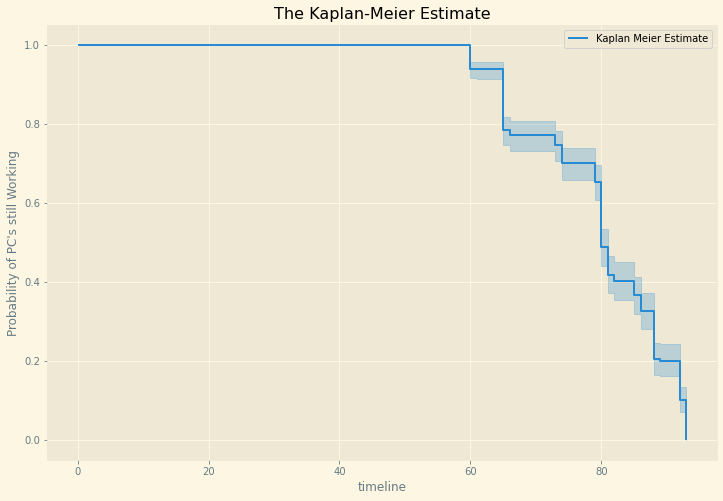

In [35]:
kmf.plot()
plt.title('The Kaplan-Meier Estimate')
plt.ylabel("Probability of PC's still Working");

I didn't find any module that replicates the survival R package. So I used the python library lifelines. I'm not sure if the results are similar